In [229]:
from scipy import *
import numpy as np
from scipy.stats import rankdata
import h5py, WLanalysis
%matplotlib inline

Using CAMB 1.0.3 installed at /Users/jia/anaconda/lib/python2.7/site-packages/camb


total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


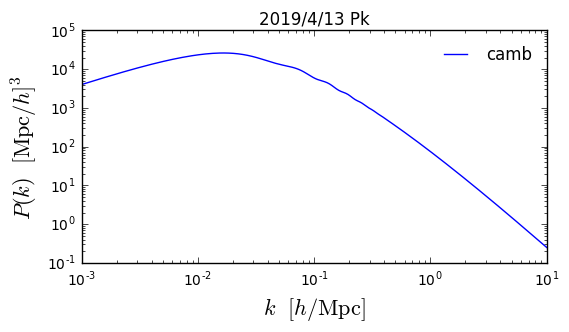

In [230]:
##########################
####### camb #############
##########################
import camb, os
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

# beyond LCDM, not implemented yet
mnu = 0.0

### derived parameters
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, omk=0, 
                   tau=0, mnu=mnu, neutrino_hierarchy='normal')
pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
pars.set_matter_power(redshifts=[0.,], kmax=5.0)

#calculate results for these parameters
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
for name in powers: print(name)
kcamb, zcamb, Pkcamb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 200)

figure(2, figsize=(6,3))
xscale('log');plt.yscale('log');plt.xlim(kcamb[0],kcamb[-1])
xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=16)
ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=16)
plot(kcamb,Pkcamb[0],'b-',label='camb')
title('2019/4/13 Pk')
legend(loc=0,frameon=0)

In [232]:
mnu, N = 0.0, 66
ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_0.0_66_parents.npy').T
idx = where( (PID0==-1) & (Mvir0>=10**11.5))[0]
ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_0.0_66_parents.npy')[idx,:].T
Cvir=Rvir/Rs

In [233]:
print len(PID),sum(PID==-1), sum(PID!=-1)

1563825 1563825 0


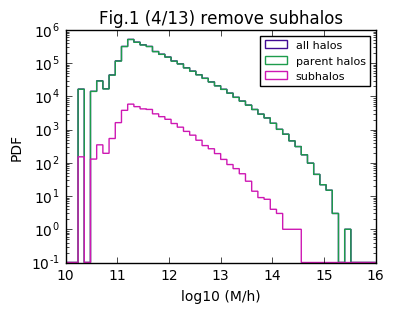

In [234]:
seed(68)
ibins=linspace(10, 16, 51)
f, ax=subplots(1,1,figsize=(4,3))
ax.hist(log10(Mvir0),bins=ibins,label='all halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0==-1]),bins=ibins,label='parent halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0!=-1]),bins=ibins,label='subhalos', 
        histtype='step',log=1,color=rand(3))
ax.legend(fontsize=8,loc=0)
ax.set_xlabel('log10 (M/h)')
ax.set_ylabel('PDF')
ax.set_title('Fig.1 (4/13) remove subhalos')
show()

In [242]:
logM = log10(Mvir)
Mcut, Mcutlo = 14.0, 12.5
logMbins0 = percentile(logM[ (logM>11.5) & (logM<Mcutlo)], linspace(0,100,101))
logMbins1 = percentile(logM[(logM>Mcutlo) & (logM<15.5)], linspace(0,100,51))
logMbins = concatenate( [logMbins0, logMbins1])
print unique(logMbins0).shape, unique(logMbins1).shape

(79,) (51,)


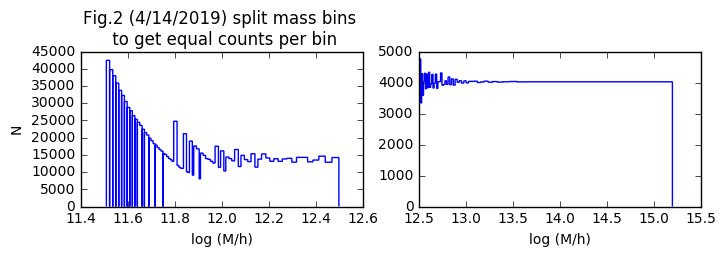

In [243]:
f, (ax1,ax2) = subplots(1,2, figsize=(8,2))
ax1.hist(logM, bins=logMbins0, histtype='step')
ax2.hist(logM, bins=logMbins1, histtype='step')
ax1.set_xlabel('log (M/h)')
ax2.set_xlabel('log (M/h)')
ax1.set_ylabel('N')
ax1.set_title('Fig.2 (4/14/2019) split mass bins \n to get equal counts per bin')
show()

In [244]:
## Cvir, Vmax, Spin
Cvir_mark = zeros(Mvir.shape)
Vmax_mark = zeros(Mvir.shape)
Spin_mark = zeros(Mvir.shape)

for i in range(len(logMbins)-1):
    iidx=where( (logM>=logMbins[i]) & (logM<logMbins[i+1]))[0]
    Cvir_mark[iidx] = rankdata(Cvir[iidx])/len(iidx)
    Vmax_mark[iidx] = rankdata(Vmax[iidx])/len(iidx)
    Spin_mark[iidx] = rankdata(Spin[iidx])/len(iidx)

In [245]:
print logM.shape, Cvir.shape, Vmax.shape, Spin.shape
print Cvir_mark.shape, Vmax_mark.shape, Spin_mark.shape

(1563825,) (1563825,) (1563825,) (1563825,)
(1563825,) (1563825,) (1563825,)


In [328]:
f, axes = subplots(1,3, figsize=(12,3))
iidx=choice(len(Cvir), len(Cvir)/1000, replace=0)
for i in range(3):
    ix=log10([Cvir, Vmax, Spin][i])
    imark=[Cvir_mark, Vmax_mark, Spin_mark][i]
    im=axes[i].scatter(10**logM[iidx], 10**ix[iidx], s=2, edgecolors='none', 
                      c=imark[iidx], cmap='inferno',vmin=0, vmax=1)
    axes[i].set_xlim(10**11.5, 10**15.5)
    axes[i].set_ylim(amin(10**ix), amax(10**ix))
    axes[i].set_xlabel(r'$M_{\rm vir}\; [h^{-1} M_\odot]$', fontsize=12)
    axes[i].set_ylabel([r'$C_{\rm vir}$', r'$V_{\rm max}$', r'${\rm Spin}$'][i], fontsize=12)
    axes[i].set_xscale('log');axes[i].set_yscale('log');
axes[0].set_ylim(2, 110)
axes[1].set_ylim(90, 2e3)
axes[2].set_ylim(8e-4, 0.8)
cax = f.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = f.colorbar(im, cax=cax, label=r'${\rm Quantile}$')
cbar.ax.tick_params(labelsize=12) 
cbar.set_ticks(linspace(-0.25, 1., 6))
#axes[0].set_title('Fig.3 (4/13) split to quantiles')
#subplots_adjust(left=0.06, bottom=0.2, right=0.98, top=0.9, wspace=0.15, hspace=0)
subplots_adjust(left=0.06, bottom=0.2, right=0.9, top=0.9, wspace=0.25, hspace=0)
savefig('plots/quantile.pdf');close()
#show()

In [195]:
Lbox = 512.0 #Mpc/h
Ngrid = 256.0
ibins=arange(Ngrid)
Lgrid = Lbox/Ngrid
dataset_name='Subsample'
Nbin=10
Mmin=11.5

def gridding (pos):
    grid = histogramdd(pos/Lbox*Ngrid,bins=[ibins,ibins,ibins])[0]
    grid = grid/mean(grid) - 1.0
    return grid

def PS (pos1, pos2, dogrid=1):
    if dogrid:
        grid1 = gridding(pos1)
        grid2 = gridding(pos2)
    else:
        grid1, grid2 = pos1, pos2
    k, ps3d = WLanalysis.CrossPowerSpectrum3D(grid1, grid2, bins=Nbin)
    return 2*pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3

def Phm_gen (mnu, N, Mcut=14.0, Mcutlo=12.5, Nbin=Nbin, Mmin=Mmin): ## position of halo and particle, in unit of Mpc/h
    ########### particles
    subsample_fn = 'snap/snapshot_mnv_%.1f/snapshot_%03d_idmod_101_0.hdf5'%(mnu,N)
    f=h5py.File(subsample_fn,'r')
    dataset = f[dataset_name]
    particle_pos = dataset['Position']/1e3
    gridP = gridding(particle_pos)
    k, Pmm = PS(gridP, gridP, dogrid=0)    

    ########### halos
    ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N)).T
    idx = where((PID0==-1)&(log10(Mvir0)>Mmin))[0]
    ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N))[idx,:].T
    Cvir=Rvir/Rs
    logM = log10(Mvir)
    halo_pos = array([x,y,z]).T
    k, Phm12 = PS(gridP, gridding(halo_pos[logM<Mcutlo]), dogrid=0)
    k, Phm14 = PS(gridP, gridding(halo_pos[logM>Mcut]), dogrid=0)
    
    ## shot noise
    Npart = len(particle_pos)
    Nmm = Lbox**3/Npart
    Nhm12 = Lbox**3/sqrt(Npart)/sqrt(sum(logM<Mcutlo))
    Nhm14 = Lbox**3/sqrt(Npart)/sqrt(sum(logM>Mcut))
    
    ####### for each AB property: 2 halo masses, hi/lo half-> 4 combinations
    
    logMbins0 = percentile(logM[(logM>Mmin) & (logM<Mcutlo)], linspace(0,100,101))
    logMbins1 = percentile(logM[(logM>Mcut) & (logM<15.5)], linspace(0,100,51))
    logMbins = unique(concatenate( [logMbins0, logMbins1]))
    
    out_AB_M12=zeros((3,2,Nbin))
    out_AB_M14=zeros((3,2,Nbin))
    Nhm_M12 = zeros((3,2))
    Nhm_M14 = zeros((3,2))
    
    i=0
    for ix in (Cvir, Vmax, Spin):
        print ['Cvir','Vmax', 'Spin'][i]
        ix_mark = zeros(logM.shape)
        for j in range(len(logMbins)-1): ####### put in mark for each mass bin
            iidx=where( (logM>logMbins[j]) & (logM<logMbins[j+1]))[0]
            ix_mark[iidx] = rankdata(ix[iidx])/len(iidx)
        k, iPhm14hi = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark>0.5) ]), dogrid=0)
        k, iPhm14lo = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark<0.5) ]), dogrid=0)
        k, iPhm12hi = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark>0.5)]), dogrid=0)
        k, iPhm12lo = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark<0.5)]), dogrid=0)   
        out_AB_M12[i]=[iPhm12hi,iPhm12lo]
        out_AB_M14[i]=[iPhm14hi,iPhm14lo] 
        i+=1
    return k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14

In [196]:
# out = Phm_gen(0.0, 66)
# save('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N),out)

Cvir
Vmax
Spin


In [199]:
############## long operation
# mnu, N = 0.0, 66
# for N in (66, 56, 47, 42, 37):
#     for mnu in (0.0, 0.1, 0.6):
#         print mnu, N
#         #out = Phm_gen(mnu, N)
#         save('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N),out)
#         out=load('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N))
#         k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14 = out

#         seed(808)
#         f, (ax,ax4,ax2) = subplots(1,3,figsize=(10,4))
#         icolor=rand(20,3)
#         ax.plot(k,Pmm,'-', lw=2,color=icolor[0],label='Pmm')
#         ax.plot(k,Phm12,'-', lw=2,color=icolor[1],label='Phm12')
#         ax.plot(k,Phm14,'-', lw=2,color=icolor[2],label='Phm14')
#         ax.plot(k,ones(len(k))*Nmm,'--',color=icolor[0])
#         ax.plot(k,ones(len(k))*Nhm12,'--',color=icolor[1])
#         ax.plot(k,ones(len(k))*Nhm14,'--',color=icolor[2])
#         ax.plot(kcamb,Pkcamb[0],'k-',label='camb')
#         ax.set_ylabel('Pk')

#         for j in range(3):
#             ilabel=['Cvir','Vmax', 'Spin'][j]
#             ax4.plot(k,out_AB_M14[j, 0]/out_AB_M14[j, 1]-1,'-',lw=2,color=icolor[3+j],label='%s'%(ilabel))

#         for j in range(3):
#             ilabel=['Cvir','Vmax', 'Spin'][j]
#             ax2.plot(k,out_AB_M12[j, 0]/out_AB_M12[j, 1]-1,'-',lw=2,color=icolor[3+j],label='%s'%(ilabel))

#         ax.set_xscale('log');ax.set_yscale('log')
#         ax2.set_xscale('log');ax4.set_xscale('log');

#         ax.set_xlim(k[3],k[-1])
#         ax2.set_xlim(k[3],k[-1])
#         ax2.plot(k,zeros(len(k)),'k-')
#         ax4.set_xlim(k[3],k[-1])
#         ax4.plot(k,zeros(len(k)),'k-')
#         ax4.set_xlabel('k')
#         ax4.set_ylabel('b_hi/b_lo-1')
#         ax2.set_ylabel('b_hi/b_lo-1')

#         ax.legend(frameon=0, fontsize=8, loc=0,ncol=2)
#         ax2.legend(frameon=0, fontsize=8, loc=0, title='M=[11.5, 12.5]')
#         ax4.legend(frameon=0, fontsize=8, loc=0, title='M=[14,15.5]')
# #         ax4.set_ylim(-0.2, 0.4)
#         ax.set_title('Fig.4 (4/13/2019) assembly bias \n Mnu=%s, snap=%i'%(mnu, N), fontsize=10)
#         plt.tight_layout()
#         #show()
#         savefig('plots/Pks_mnu%.1f_%i.jpg'%(mnu,N))
#         close()

In [201]:
a_arr = array([1.0, 0.678818, 0.488158, 0.403786, 0.330213])
N_arr = array([66, 56, 47, 42, 37])
z_arr = 1.0/a_arr-1
print z_arr

[0.         0.47314891 1.04851708 1.47655937 2.02834837]


In [203]:
#k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14
out0_arr = [load('Phm/Pks_mnu%.1f_%i.npy'%(0.0,N)) for N in N_arr[:3]]

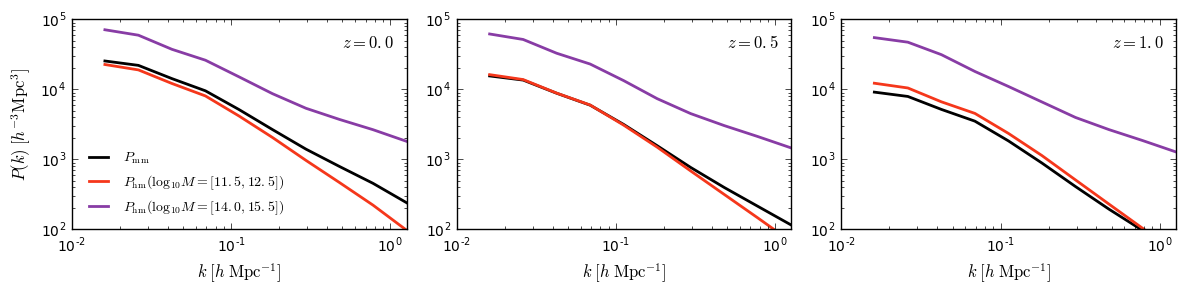

In [336]:
seed(808)
colors=rand(20,3)
f, axes = subplots(1,3, figsize=(12,3))
for i in range(3):
    k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14 = out0_arr[i]
    axes[i].plot(k, Pmm, color='k', lw=2, label=r'$P_{\rm mm}$')
    axes[i].plot(k, Phm12, color=colors[0], lw=2, label=r'$P_{\rm hm} (\log_{10}M=[11.5,12.5])$')
    axes[i].plot(k, Phm14, color=colors[2], lw=2, label=r'$P_{\rm hm} (\log_{10}M=[14.0,15.5])$')
    axes[i].set_xscale('log'), axes[i].set_yscale('log')
    axes[i].set_xlim(1e-2,k[-1]);axes[i].set_ylim(1e2, 1e5)
    axes[i].text(0.5, 4e4, r'$z=%.1f$'%(z_arr[i]), fontsize=12)
    axes[i].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=12)
axes[0].set_ylabel(r'$P(k)\; [h^{-3} {\rm Mpc}^{3}]$', fontsize=12)
axes[0].legend(loc='lower left', frameon=0, fontsize=10)
subplots_adjust(left=0.06, bottom=0.2, right=0.98, top=0.9, wspace=0.15, hspace=0)
show()
#savefig('plots/Pk.pdf');close()